In [1]:
import numpy as np
import pandas as pd
import time, warnings
import datetime as dt
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [3]:
retail_df = pd.read_csv("data.csv",encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
retail_df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [5]:
retail_FR = retail_df[retail_df['Country']=='United Kingdom']
retail_FR.shape

(495478, 8)

In [6]:
retail_FR = retail_FR[retail_FR['Quantity']>0]
retail_FR.shape

(486286, 8)

In [7]:
retail_FR.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_FR.shape

(354345, 8)

In [8]:
retail_FR = retail_FR[retail_FR['InvoiceDate']>= "2010-12-09"]
retail_FR.shape

(176137, 8)

In [9]:
print("Summary..")
print("Number of transactions: ", retail_FR['InvoiceNo'].nunique())
print("Number of products bought: ",retail_FR['StockCode'].nunique())
print("Number of customers:", retail_FR['CustomerID'].nunique() )

Summary..
Number of transactions:  8789
Number of products bought:  3294
Number of customers: 2864


In [10]:
retail_FR['InvoiceDate'].max()

'9/9/2011 9:52'

In [11]:
import time, warnings
import datetime as dt

reference_datepoint = dt.date(2011,12,9)
print(reference_datepoint)

2011-12-09


In [12]:
retail_FR['date'] = pd.DatetimeIndex(retail_FR['InvoiceDate']).date
retail_FR.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,2011-03-01
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,2011-03-01
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,2011-03-01


In [13]:
recency_df = retail_FR.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12747,2011-08-22
1,12748,2011-09-30
2,12749,2011-08-01
3,12820,2011-09-26
4,12821,2011-05-09


In [14]:
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (reference_datepoint - x).days)

In [15]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12747,2011-08-22,109
1,12748,2011-09-30,70
2,12749,2011-08-01,130
3,12820,2011-09-26,74
4,12821,2011-05-09,214


In [16]:
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

In [17]:
# drop duplicates
retail_FR_copy = retail_FR
retail_FR_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)


#calculate frequency of purchases
frequency_df = retail_FR_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12747,5
1,12748,96
2,12749,3
3,12820,1
4,12821,1


In [18]:
retail_FR['TotalCost'] = retail_FR['Quantity'] * retail_FR['UnitPrice']

In [19]:
monetary_df = retail_FR.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12747,191.85
1,12748,1054.43
2,12749,67.00
3,12820,15.00
4,12821,19.92


In [20]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,109,5,191.85
12748,70,96,1054.43
12749,130,3,67.00
12820,74,1,15.00
12821,214,1,19.92


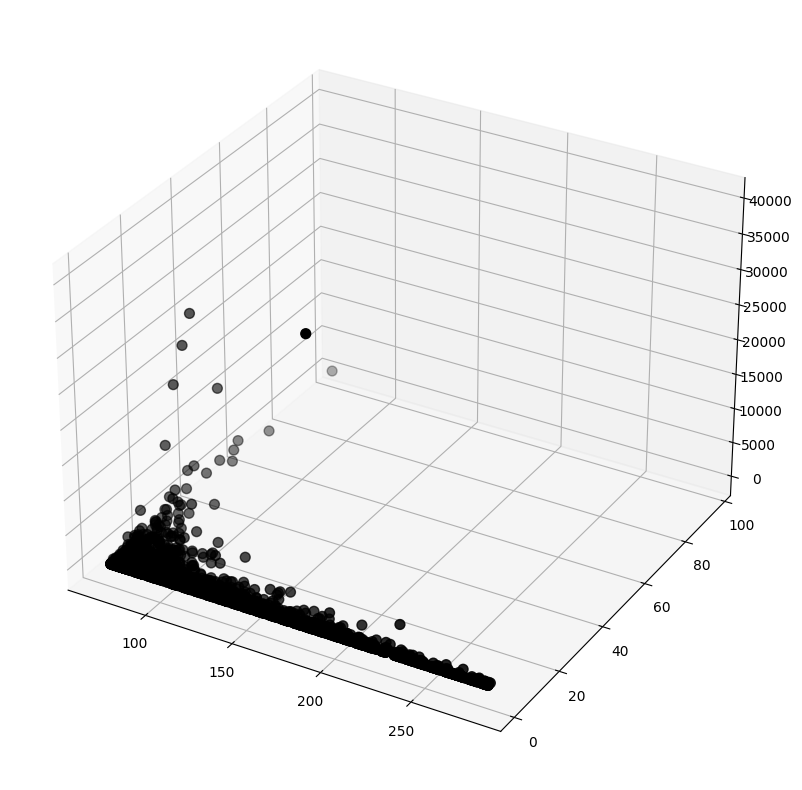

In [21]:
plt.figure(figsize = (20,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_df['Recency'],rfm_df['Frequency'],rfm_df['Monetary'],s = 50, c = 'black')

In [22]:
rfm_df['Recency'] = np.log(rfm_df['Recency'])
rfm_df['Frequency'] = np.log(rfm_df['Frequency'])
rfm_df['Monetary'] = np.log(rfm_df['Monetary'])

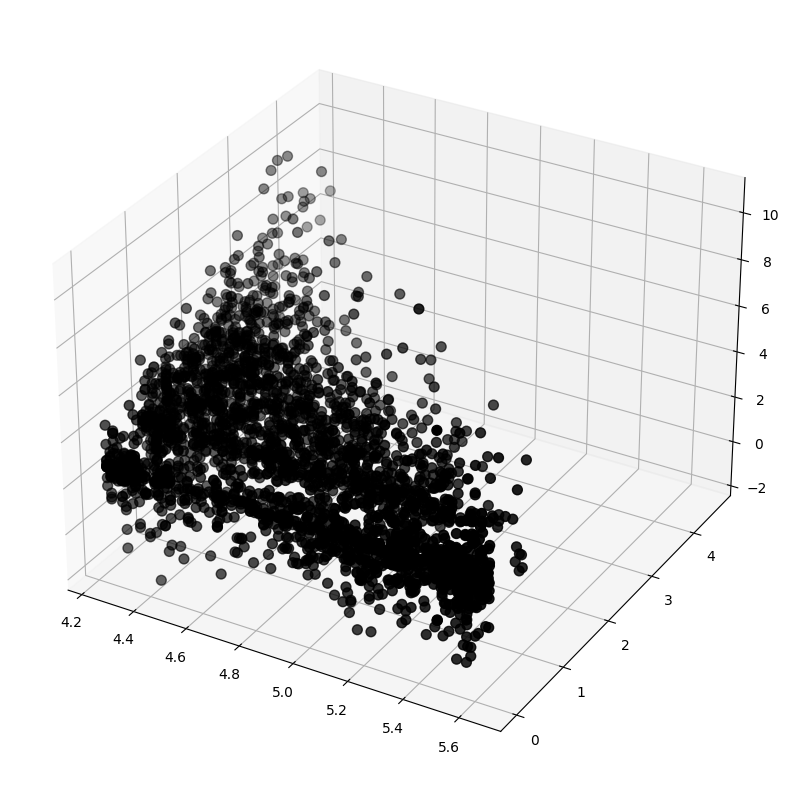

In [23]:
plt.figure(figsize = (20,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_df['Recency'],rfm_df['Frequency'],rfm_df['Monetary'],s = 50, c = 'black')

In [26]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(2)
df = pca.fit_transform(rfm_df)

In [28]:
columnas = ['col1', 'col2']
df_sns = pd.DataFrame(df, columns=columnas)

In [29]:
df_sns.head()

,col1,col2
0,1.790354,-0.144368
1,4.571258,-2.053725
2,0.609192,-0.087622
3,-1.125403,-0.013833
4,-0.990349,0.512524


In [36]:
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score
import seaborn as sns

In [43]:
clusters_agglomerative = AgglomerativeClustering(n_clusters=3).fit_predict(df)
clusters_k_means = KMeans(n_clusters = 3).fit_predict(df)
clusters_gmm = GaussianMixture(n_components = 3).fit_predict(df)
clusters_bgmm = BayesianGaussianMixture(n_components = 3).fit_predict(df)
clusters_mbkmeans = MiniBatchKMeans(n_clusters=3).fit_predict(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='col1', ylabel='col2'>

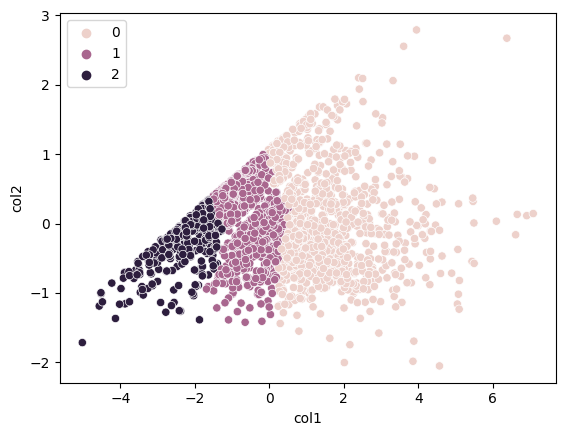

In [38]:
sns.scatterplot(data=df_sns, x='col1', y='col2', hue=clusters_agglomerative)

In [39]:
silhouette_avg1 = silhouette_score(df,clusters_agglomerative)
silhouette_avg1

0.36946073676843344

<Axes: xlabel='col1', ylabel='col2'>

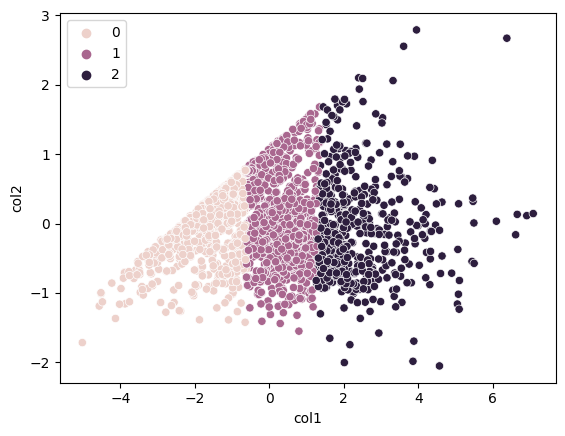

In [40]:
sns.scatterplot(data=df_sns, x='col1', y='col2', hue=clusters_k_means)

In [44]:
silhouette_avg2 = silhouette_score(df, clusters_k_means)
silhouette_avg2

0.40649935057970193

<Axes: xlabel='col1', ylabel='col2'>

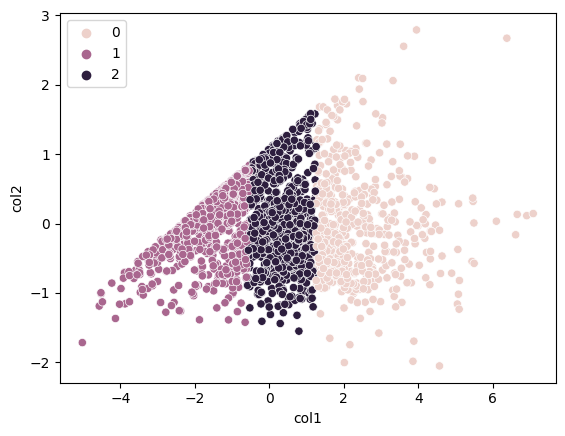

In [52]:
sns.scatterplot(data=df_sns, x='col1', y='col2', hue=clusters_mbkmeans)

In [54]:
silhouette_avg5 = silhouette_score(df, clusters_mbkmeans)
silhouette_avg5

0.4026898343819055

<Axes: xlabel='col1', ylabel='col2'>

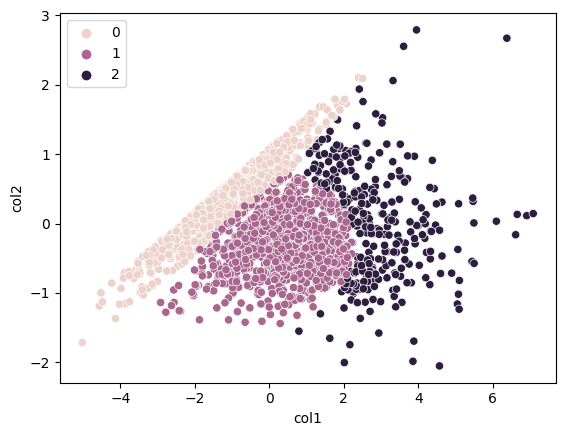

In [46]:
sns.scatterplot(data=df_sns, x='col1', y='col2', hue=clusters_gmm)

In [47]:
silhouette_avg3 = silhouette_score(df, clusters_gmm)
silhouette_avg3

0.27679124788802995

<Axes: xlabel='col1', ylabel='col2'>

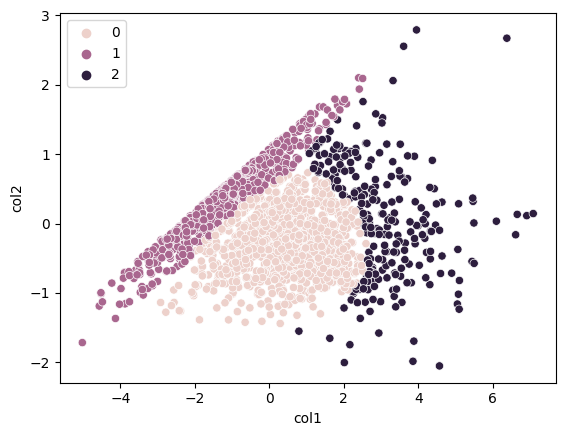

In [49]:
sns.scatterplot(data=df_sns, x='col1', y='col2', hue=clusters_bgmm)

In [53]:
silhouette_avg4 = silhouette_score(df, clusters_bgmm)
silhouette_avg4

0.26490167714149737

In [55]:
#Copy this cell wherever you want without thinking 👌

# (I sacrifice readability and devise ways to make memory errors less likely to occur.)
import numpy as np
import pandas as pd
from tqdm import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

def clustering_ensemble(clusters_list, weights = None, threshold = 0.5, size_max = 18000, cls_num_min = 7):
    """
    Parameters:
                clusters_list:  List of numpy arrays, representing the cluster_id of each data point
                weights:        List representing the voting weight, for example = [0.5, 0.5]. default None (uses uniform weights)
                threshold:      float(0.0, 1.0), the threshold for determining an edge in the sparse matrix, default 0.5
                size_max:       The maximum size of a cluster, default 18000
                cls_num_min:    The minimum number of clusters, default 7
    Returns:
                clusters_final: An ensemble of the clustering algorithms predictions.
    weights: Where the ensemble results are the same as before the ensemble, when it does not work, tweaking here may work.
    threshold: The larger the larger, the faster; If you don't have enough memory, try making it bigger.
    """
    # zip same cluster.
    cls_tup_list = []
    for cls_tup in zip(*clusters_list):
        cls_tup_list.append(cls_tup)
    zipper = {x: i for i, x in enumerate(sorted(set(cls_tup_list)))}
    zipped_list = [zipper[x] for x in cls_tup_list]
    unzipper = defaultdict(set)
    for idx, cls_tup in enumerate(cls_tup_list):
        zipped = zipper[cls_tup]
        unzipper[zipped].add(idx)
    comp_clusters_list = [[-1]*len(zipper) for _ in range(len(clusters_list))]
    node_end = len(comp_clusters_list[0])
    print(node_end)
    for clusters, comp_clusters in zip(clusters_list, comp_clusters_list):
        for i, cluster_i in enumerate(clusters):
                value = zipped_list[i]
                comp_clusters[value] = cluster_i
    # calc adjacency matrix(sparse). and calc score(weighted average)
    # memory error. OMG. I created my own simple. I believe that the reduction in space computation by creating the system by oneself is more advantageous than the constant-doubling speed-up by numpy.
    def create_sparse_matrix(clusters):
        sparse = defaultdict(lambda :defaultdict(int))  # High speed by utilizing cache memory. sparse[(node1, node2)] is slow.
        # if clusters[node1] == clusters[node2] then sparse[node1][node2] = 1
        cluster_idx_of = defaultdict(set)  # cls_inx_of[clster] = set(idx)
        for idx, cluster in enumerate(clusters):
            cluster_idx_of[cluster].add(idx)
        for cluster, idx_list in cluster_idx_of.items():
            for node1 in idx_list:
                for node2 in idx_list:
                    sparse[node1][node2] = 1
        return sparse
    sparse_matrix_list = [create_sparse_matrix(comp_clusters) for comp_clusters in tqdm(comp_clusters_list)]
    if weights is None: weights = [1 / len(sparse_matrix_list) for i in range(len(sparse_matrix_list))]
    weights = np.asarray(weights) / np.sum(weights)
    # Define edge_list (val, node1, node2).
    # However, if you do it normally, there is not enough memory because sparse_matrix_mean is not sparse. By processing every node1, the amount of space calculation is greatly reduced.
    edge_list = []  # [(val, node1, node2), ...]
    for node1 in trange(node_end):
        sparse_matrix_mean = defaultdict(int)
        for sparce_matrix, weight in zip(sparse_matrix_list, weights):
            col = sparce_matrix[node1]
            for node2, val in col.items():
                sparse_matrix_mean[node2] += val*weight
            for node2, val in sparse_matrix_mean.items():
                if val < threshold or node1 >= node2:
                    continue
                edge_list.append((val, node1, node2))
    edge_list.sort(reverse=True)
    class DSU:
        def __init__(self, node_end, unzipper):
            self.par = [i for i in range(node_end)]
            self.siz = [len(unzipper[i]) for i in range(node_end)]
            self.cls_num = node_end  # To use the cls_num variable, we declared this class
        def find(self, x):
            if self.par[x] == x: return x
            self.par[x] = self.find(self.par[x])
            return self.par[x]
        def union(self, x, y):
            x = self.find(x)
            y = self.find(y)
            if x == y:
                return
            if self.siz[x] > self.siz[y]: x, y = y, x
            self.par[x] = y
            self.siz[y] += self.siz[x]
            self.cls_num -= 1
        def get_siz(self, x):
            x = self.find(x)
            return self.siz[x]
    dsu = DSU(node_end, unzipper)
    for w, fr, to in edge_list:
        if (dsu.get_siz(fr)+dsu.get_siz(to)) > size_max: continue
        dsu.union(fr, to)
        if dsu.cls_num <= cls_num_min:
            print("number of clusters reaches cls_num_min: {}".format(cls_num_min), " break.")
            break
    # Unzip the zipped array.
    clusters_final = [0]*len(clusters_list[0])
    for node in range(node_end):
        cluster_id = dsu.find(node)
        idx_list = unzipper[node]
        for idx in idx_list:
            clusters_final[idx] = cluster_id
    # Renumbered for easier viewing.
    zipper = {x: i for i, x in enumerate(sorted(set(clusters_final)))}
    clusters_final = [zipper[x] for x in clusters_final]
    return clusters_final

# Not relevant for ensembles, but if you want to check the result, copy the following as well
# https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
def compare_clusterings(y1, y2, title=''):
    """Show the adjusted rand score and plot the two clusterings in color"""
    ars = adjusted_rand_score(y1, y2)
    n1 = y1.max() + 1
    n2 = y2.max() + 1
    argsort = np.argsort(y1*100 + y2) if n1 >= n2 else np.argsort(y2*100 + y1)
    plt.figure(figsize=(16, 0.5))
    for i in range(6, 11):
        plt.scatter(np.arange(len(y1)), np.full_like(y1, i), c=y1[argsort], s=1, cmap='tab10')
    for i in range(5):
        plt.scatter(np.arange(len(y2)), np.full_like(y2, i), c=y2[argsort], s=1, cmap='tab10')
    plt.gca().axis('off')
    plt.title(f'{title}\nAdjusted Rand score: {ars:.5f}')
    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()

7


100%|██████████| 7/7 [00:00<00:00, 24713.91it/s]


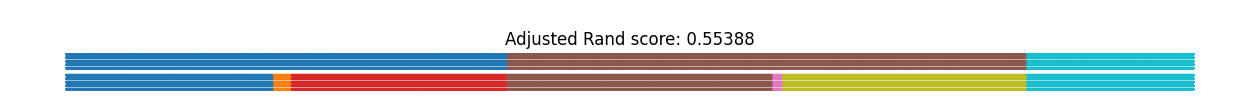

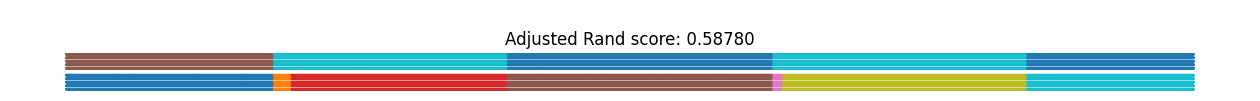

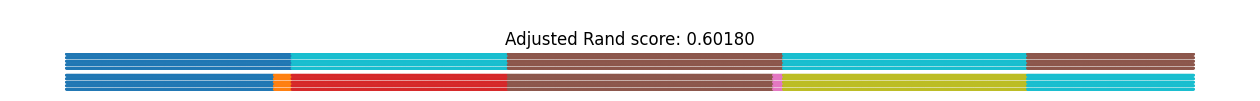

In [57]:
clusters_list = [clusters_agglomerative,clusters_k_means,clusters_mbkmeans]
ensemble_preds = clustering_ensemble(clusters_list, weights = None, threshold=1, cls_num_min = 3)
for clusters in clusters_list: compare_clusterings(np.array(clusters), np.array(ensemble_preds))

<Axes: xlabel='col1', ylabel='col2'>

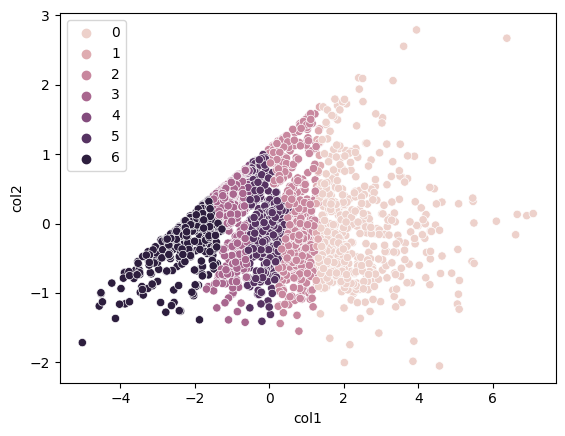

In [58]:
sns.scatterplot(data=df_sns, x='col1', y='col2', hue=ensemble_preds)